# Player Direction Prediction - Image-Only Baseline

**Ablation Study:** Training without bbox_pitch spatial context

This notebook trains a baseline model using **only image features** (no pitch coordinates).
Compare results with full model to measure impact of spatial context.

---


## 1. Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Imports and Setup

In [3]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Vision imports
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Standard imports
import numpy as np
import json
import math
from pathlib import Path
from collections import defaultdict
import time
from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: Tesla T4
CUDA Version: 12.6


## 3. Configuration

**⚠️ IMPORTANT: Update the paths below to match your Google Drive structure!**

In [4]:
# Configuration - Optimized for 3,700 samples
CONFIG = {
    # Data paths
    'dataset_root': '/content/drive/MyDrive/player_direction_dataset',
    'save_dir': '/content/drive/MyDrive/player_direction_checkpoints_4059_optimized_without_bbox',

    # Data loading
    'batch_size': 48,       # ← Larger batch (more stable gradients)
    'num_workers': 0,
    'image_size': 224,

    # Model
    'backbone': 'resnet50',
    'dropout': 0.5,         # ← Reduced (less aggressive with more data)
    'freeze_backbone': False,

    # Training
    'epochs': 250,          # ← More epochs (model needs time)
    'lr': 1e-4,          # ← Slightly higher (faster convergence)
    'weight_decay': 5e-6,   # ← Less regularization (more data = less needed)
    'patience': 40,         # ← Very patient (wait for convergence)

    # Checkpointing
    'save_best': True
}

## 4. Dataset Class with Pitch Coordinates

In [5]:
class PlayerDirectionDataset(Dataset):
    """
    Dataset for player direction prediction (IMAGE-ONLY)

    Returns only:
    - image: Player crop
    - direction: Ground truth direction as unit vector (cos θ, sin θ)

    NO bbox_pitch returned!
    """

    def __init__(self, labels, root_dir, transform=None, augment=False):
        self.labels = labels
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]

        # Load image
        img_path = self.root_dir / 'images' / label['filename']
        img = Image.open(img_path).convert('RGB')

        # Get angle
        angle = label['direction_degree']

        # Geometric augmentation
        if self.augment:
            # Horizontal flip: mirror angle
            if np.random.random() > 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                angle = (180 - angle) % 360

            # Small rotation
            if np.random.random() > 0.7:
                rotation = np.random.uniform(-10, 10)
                img = img.rotate(rotation, fillcolor=(0, 0, 0))
                angle = (angle - rotation) % 360

        # Apply transforms
        if self.transform:
            img = self.transform(img)

        # Convert angle to unit vector
        angle_rad = math.radians(angle)
        direction = torch.tensor([math.cos(angle_rad), math.sin(angle_rad)],
                                dtype=torch.float32)

        return img, direction  # Only image and direction!

print("✓ Image-only dataset defined")
print("  Returns: (image, direction)")
print("  NO bbox_pitch!")


✓ Image-only dataset defined
  Returns: (image, direction)
  NO bbox_pitch!


In [6]:
def create_dataloaders(dataset_root, batch_size=32, num_workers=4, image_size=224):
    """
    Create train/validation/test dataloaders (IMAGE-ONLY)

    Returns only image and direction - NO bbox_pitch!
    """
    dataset_root = Path(dataset_root)

    # Load labels
    with open(dataset_root / 'train' / 'labels.json') as f:
        train_labels = json.load(f)

    with open(dataset_root / 'valid' / 'labels.json') as f:
        valid_labels = json.load(f)

    with open(dataset_root / 'test' / 'labels.json') as f:
        test_labels = json.load(f)


    # Filter samples with valid data
    def is_valid_sample(label):
        # Just need image and direction
        return 'direction_degree' in label and 'filename' in label

    train_labels = [l for l in train_labels if is_valid_sample(l)]
    valid_labels = [l for l in valid_labels if is_valid_sample(l)]
    test_labels = [l for l in test_labels if is_valid_sample(l)]

    print(f"Train samples: {len(train_labels)}")
    print(f"Valid samples: {len(valid_labels)}")
    print(f"Test samples: {len(test_labels)}")

    # Create transforms
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    valid_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = PlayerDirectionDataset(
        train_labels,
        dataset_root / 'train',
        transform=train_transform,
        augment=True
    )

    valid_dataset = PlayerDirectionDataset(
        valid_labels,
        dataset_root / 'valid',
        transform=valid_transform,
        augment=False
    )

    test_dataset = PlayerDirectionDataset(
        test_labels,
        dataset_root / 'test',
        transform=valid_transform,
        augment=False
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return {
        'train': train_loader,
        'valid': valid_loader,
        'test': test_loader,
        'train_size': len(train_dataset),
        'valid_size': len(valid_dataset),
        'test_size': len(test_dataset)
    }

## 5. Model Architecture

In [7]:
class PlayerDirectionModel(nn.Module):
    """
    Image-only baseline model (NO bbox_pitch)

    Architecture:
    1. CNN backbone (ResNet) for image features
    2. Direction prediction head (unit vector output)

    This is an ablation baseline to measure impact of spatial context.
    """

    def __init__(self, backbone='resnet50', dropout=0.5, freeze_backbone=False):
        super().__init__()

        # Image encoder (CNN backbone)
        if backbone == 'resnet18':
            resnet = models.resnet18(pretrained=True)
            image_feat_dim = 512
        elif backbone == 'resnet34':
            resnet = models.resnet34(pretrained=True)
            image_feat_dim = 512
        elif backbone == 'resnet50':
            resnet = models.resnet50(pretrained=True)
            image_feat_dim = 2048
        elif backbone == 'resnet101':
            resnet = models.resnet101(pretrained=True)
            image_feat_dim = 2048
        else:
            raise ValueError(f"Unknown backbone: {backbone}")

        # Remove final classification layer
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Optionally freeze backbone
        if freeze_backbone:
            for param in self.image_encoder.parameters():
                param.requires_grad = False

        # Direction prediction head (image features → 2D unit vector)
        self.direction_head = nn.Sequential(
            nn.Linear(image_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 2)  # Output: (cos θ, sin θ)
        )

    def forward(self, image, bbox=None):
        """
        Forward pass

        Args:
            image: [B, 3, H, W] - Input images
            bbox: Ignored (kept for compatibility with dataset)

        Returns:
            direction: [B, 2] - Normalized direction vectors (cos θ, sin θ)
        """
        # Extract image features
        img_features = self.image_encoder(image)  # [B, feat_dim, 1, 1]
        img_features = img_features.view(img_features.size(0), -1)  # [B, feat_dim]

        # Predict direction (no bbox fusion!)
        direction = self.direction_head(img_features)  # [B, 2]

        # Normalize to unit vector
        direction = F.normalize(direction, p=2, dim=1)

        return direction

print("✓ Image-only baseline model defined")
print("  - No bbox encoder")
print("  - No fusion layer")
print("  - Direct: image features → direction prediction")


✓ Image-only baseline model defined
  - No bbox encoder
  - No fusion layer
  - Direct: image features → direction prediction


## 6. Loss Function and Metrics

In [8]:
def cosine_similarity_loss(pred, target):
    """
    Cosine similarity loss for unit vectors
    Loss = 1 - cos(pred, target)

    Range: [0, 2]
    - 0 = perfect match (0° aligned)
    - 1 = perpendicular (90° error)
    - 2 = opposite (180° error)
    """
    return 1 - F.cosine_similarity(pred, target, dim=1).mean()


def angular_error(pred, target):
    """
    Calculate angular error in degrees

    Args:
        pred: [B, 2] - Predicted unit vectors
        target: [B, 2] - Target unit vectors

    Returns:
        error: Mean angular error in degrees
    """
    # Cosine similarity
    cos_sim = F.cosine_similarity(pred, target, dim=1)

    # Clamp to avoid numerical issues with arccos
    cos_sim = torch.clamp(cos_sim, -1.0, 1.0)

    # Angular error in radians
    error_rad = torch.acos(cos_sim)

    # Convert to degrees
    error_deg = torch.rad2deg(error_rad)

    return error_deg.mean().item()


def vector_to_angle(vector):
    """
    Convert unit vector to angle in degrees

    Args:
        vector: [..., 2] - Unit vectors [cos, sin]

    Returns:
        angles: [...] - Angles in degrees [0, 360)
    """
    angles_rad = torch.atan2(vector[..., 1], vector[..., 0])
    angles_deg = torch.rad2deg(angles_rad)
    angles_deg = (angles_deg + 360) % 360  # Ensure [0, 360)
    return angles_deg

## 7. Training Functions

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()

    total_loss = 0.0
    total_angular_error = 0.0
    num_batches = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, directions in pbar:
        # Move to device
        images = images.to(device)
        directions = directions.to(device)

        # Forward pass
        optimizer.zero_grad()
        pred_directions = model(images)

        # Compute loss
        loss = criterion(pred_directions, directions)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        total_angular_error += angular_error(pred_directions, directions)
        num_batches += 1

        # Update progress bar
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'angle_err': f"{angular_error(pred_directions, directions):.2f}°"
        })

    return total_loss / num_batches, total_angular_error / num_batches


def evaluate(model, dataloader, criterion, device):
    """Evaluate on validation/test set"""
    model.eval()

    total_loss = 0.0
    total_angular_error = 0.0
    num_batches = 0

    all_errors = []

    with torch.no_grad():
        for images, directions in tqdm(dataloader, desc='Evaluating'): # FIX: Removed '_' as dataloader only returns 2 items
            # Move to device
            images = images.to(device)
            directions = directions.to(device)

            # Forward pass
            pred_directions = model(images)

            # Compute loss
            loss = criterion(pred_directions, directions)

            # Metrics
            total_loss += loss.item()

            # Individual angular errors
            cos_sim = F.cosine_similarity(pred_directions, directions, dim=1)
            cos_sim = torch.clamp(cos_sim, -1.0, 1.0)
            errors = torch.rad2deg(torch.acos(cos_sim))
            all_errors.extend(errors.cpu().numpy())

            total_angular_error += errors.mean().item()
            num_batches += 1

    return {
        'loss': total_loss / num_batches,
        'angular_error': total_angular_error / num_batches,
        'all_errors': np.array(all_errors)
    }

## 8. Load Data

In [10]:
# Create dataloaders
print("Creating dataloaders...")
dataloaders = create_dataloaders(
    dataset_root=CONFIG['dataset_root'],
    batch_size=CONFIG['batch_size'],
    num_workers=CONFIG['num_workers'],
    image_size=CONFIG['image_size']
)

# Check if dataloaders were created
if not dataloaders:
    raise RuntimeError("No dataloaders created! Check your dataset path.")

# Print dataset sizes
print("\nDataset sizes:")
# Print dataset sizes
for split in ['train', 'valid']:
    loader = dataloaders[split]
    print(f"  {split}: {len(loader.dataset)} samples ({len(loader)} batches)")

# Test loading a batch
print("\nTest batch loading:")
# Load a test batch
test_images, test_directions = next(iter(dataloaders["train"]))
images = test_images
directions = test_directions
# Convert directions back to angles for display
angles = torch.atan2(directions[:, 1], directions[:, 0]) * 180 / np.pi
angles = (angles + 360) % 360  # Ensure [0, 360)
print(f"  Images shape: {images.shape}")
print(f"  Directions shape: {directions.shape}")
print(f"  Sample angles: {angles[:5].numpy()}")




Creating dataloaders...
Train samples: 3044
Valid samples: 608
Test samples: 407

Dataset sizes:
  train: 3044 samples (64 batches)
  valid: 608 samples (13 batches)

Test batch loading:
  Images shape: torch.Size([48, 3, 224, 224])
  Directions shape: torch.Size([48, 2])
  Sample angles: [ 99.48184 153.75623 184.57393 175.87244 270.     ]


## 9. Create Model

In [11]:
# Create model
print("Creating model...")
model = PlayerDirectionModel(
    backbone=CONFIG['backbone'],
    dropout=CONFIG['dropout'],
    freeze_backbone=CONFIG['freeze_backbone']
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel: {CONFIG['backbone']}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
print("\nTesting forward pass...")
with torch.no_grad():
    test_out = model(images.to(device))
    print(f"Output shape: {test_out.shape}")
    print(f"Output is normalized: {torch.allclose(torch.norm(test_out, dim=1), torch.ones(test_out.size(0)).to(device))}")
    print(f"Sample predictions (unit vectors): {test_out[:3].cpu().numpy()}")

Creating model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]



Model: resnet50
Total parameters: 24,688,962
Trainable parameters: 24,688,962

Testing forward pass...
Output shape: torch.Size([48, 2])
Output is normalized: True
Sample predictions (unit vectors): [[ 0.15034918  0.988633  ]
 [ 0.98168194 -0.19052702]
 [ 0.519122   -0.85470015]]


## 10. Setup Training

In [12]:
## 10. Setup Training

# Loss function
criterion = cosine_similarity_loss

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['lr'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print("Training setup complete!")
print(f"  Optimizer: Adam (lr={CONFIG['lr']}, wd={CONFIG['weight_decay']})")
print(f"  Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)")
print(f"  Loss: Cosine Similarity Loss")
print(f"  Checkpoints will be saved to: {CONFIG['save_dir']}")

Training setup complete!
  Optimizer: Adam (lr=0.0001, wd=5e-06)
  Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)
  Loss: Cosine Similarity Loss
  Checkpoints will be saved to: /content/drive/MyDrive/player_direction_checkpoints_4059_optimized_without_bbox


## 11. Training Loop

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_angle_error': [],
    'valid_loss': [],
    'valid_angle_error': []
}

best_valid_loss = float('inf')
patience_counter = 0

# Ensure the save directory exists
Path(CONFIG['save_dir']).mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

for epoch in range(CONFIG['epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 70)

    # Train
    train_loss, train_angle_error = train_epoch(
        model, dataloaders['train'], criterion, optimizer, device
    )

    # Validate
    valid_metrics = evaluate(model, dataloaders['valid'], criterion, device)

    # Update scheduler
    scheduler.step(valid_metrics['loss'])

    # Save history
    history['train_loss'].append(train_loss)
    history['train_angle_error'].append(train_angle_error)
    history['valid_loss'].append(valid_metrics['loss'])
    history['valid_angle_error'].append(valid_metrics['angular_error'])

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Angle Error: {train_angle_error:.2f}°")
    print(f"  Valid Loss: {valid_metrics['loss']:.4f} | Angle Error: {valid_metrics['angular_error']:.2f}°")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if valid_metrics['loss'] < best_valid_loss:
        best_valid_loss = valid_metrics['loss']
        patience_counter = 0

        if CONFIG['save_best']:
            checkpoint_path = Path(CONFIG['save_dir']) / 'best_model.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_loss': valid_metrics['loss'],
                'valid_angle_error': valid_metrics['angular_error'],
                'config': CONFIG
            }, checkpoint_path)
            print(f"  ✓ Saved best model (val_loss: {best_valid_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{CONFIG['patience']}")

    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Best validation loss: {best_valid_loss:.4f}")


STARTING TRAINING

Epoch 1/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.9646 | Angle Error: 87.51°
  Valid Loss: 0.9614 | Angle Error: 87.48°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.9614)

Epoch 2/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.9163 | Angle Error: 83.70°
  Valid Loss: 0.9101 | Angle Error: 83.51°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.9101)

Epoch 3/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.8039 | Angle Error: 75.62°
  Valid Loss: 0.8044 | Angle Error: 76.01°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.8044)

Epoch 4/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 0.7349 | Angle Error: 70.47°
  Valid Loss: 0.7674 | Angle Error: 73.03°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.7674)

Epoch 5/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 0.6815 | Angle Error: 66.52°
  Valid Loss: 0.8136 | Angle Error: 76.46°
  LR: 0.000100
  Patience: 1/40

Epoch 6/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 0.7161 | Angle Error: 69.19°
  Valid Loss: 0.5957 | Angle Error: 60.68°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.5957)

Epoch 7/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 0.5582 | Angle Error: 57.51°
  Valid Loss: 0.5366 | Angle Error: 55.08°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.5366)

Epoch 8/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 0.5110 | Angle Error: 53.79°
  Valid Loss: 0.5779 | Angle Error: 58.85°
  LR: 0.000100
  Patience: 1/40

Epoch 9/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss: 0.4698 | Angle Error: 50.47°
  Valid Loss: 0.6476 | Angle Error: 63.70°
  LR: 0.000100
  Patience: 2/40

Epoch 10/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss: 0.4550 | Angle Error: 49.36°
  Valid Loss: 0.4996 | Angle Error: 52.57°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.4996)

Epoch 11/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 11 Summary:
  Train Loss: 0.4090 | Angle Error: 45.83°
  Valid Loss: 0.4725 | Angle Error: 50.70°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.4725)

Epoch 12/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 12 Summary:
  Train Loss: 0.3486 | Angle Error: 41.29°
  Valid Loss: 0.4434 | Angle Error: 48.16°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.4434)

Epoch 13/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 13 Summary:
  Train Loss: 0.3654 | Angle Error: 42.40°
  Valid Loss: 0.4594 | Angle Error: 49.48°
  LR: 0.000100
  Patience: 1/40

Epoch 14/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 14 Summary:
  Train Loss: 0.3323 | Angle Error: 40.18°
  Valid Loss: 0.4564 | Angle Error: 48.87°
  LR: 0.000100
  Patience: 2/40

Epoch 15/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 15 Summary:
  Train Loss: 0.3887 | Angle Error: 44.22°
  Valid Loss: 0.4624 | Angle Error: 49.84°
  LR: 0.000100
  Patience: 3/40

Epoch 16/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 16 Summary:
  Train Loss: 0.3500 | Angle Error: 41.31°
  Valid Loss: 0.4441 | Angle Error: 48.14°
  LR: 0.000100
  Patience: 4/40

Epoch 17/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 17 Summary:
  Train Loss: 0.3225 | Angle Error: 38.96°
  Valid Loss: 0.4013 | Angle Error: 45.46°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.4013)

Epoch 18/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 18 Summary:
  Train Loss: 0.3324 | Angle Error: 39.79°
  Valid Loss: 0.3579 | Angle Error: 42.29°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.3579)

Epoch 19/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 19 Summary:
  Train Loss: 0.3504 | Angle Error: 41.34°
  Valid Loss: 0.3992 | Angle Error: 44.43°
  LR: 0.000100
  Patience: 1/40

Epoch 20/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 20 Summary:
  Train Loss: 0.4115 | Angle Error: 46.01°
  Valid Loss: 0.4011 | Angle Error: 45.18°
  LR: 0.000100
  Patience: 2/40

Epoch 21/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 21 Summary:
  Train Loss: 0.3274 | Angle Error: 39.51°
  Valid Loss: 0.3999 | Angle Error: 44.79°
  LR: 0.000100
  Patience: 3/40

Epoch 22/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 22 Summary:
  Train Loss: 0.2846 | Angle Error: 36.08°
  Valid Loss: 0.4160 | Angle Error: 45.89°
  LR: 0.000100
  Patience: 4/40

Epoch 23/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 23 Summary:
  Train Loss: 0.2960 | Angle Error: 36.64°
  Valid Loss: 0.4106 | Angle Error: 45.64°
  LR: 0.000100
  Patience: 5/40

Epoch 24/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 24 Summary:
  Train Loss: 0.3709 | Angle Error: 42.95°
  Valid Loss: 0.3443 | Angle Error: 40.46°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.3443)

Epoch 25/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 25 Summary:
  Train Loss: 0.2802 | Angle Error: 35.68°
  Valid Loss: 0.3616 | Angle Error: 42.35°
  LR: 0.000100
  Patience: 1/40

Epoch 26/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 26 Summary:
  Train Loss: 0.2713 | Angle Error: 35.12°
  Valid Loss: 0.3557 | Angle Error: 41.71°
  LR: 0.000100
  Patience: 2/40

Epoch 27/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 27 Summary:
  Train Loss: 0.2666 | Angle Error: 34.65°
  Valid Loss: 0.4052 | Angle Error: 45.35°
  LR: 0.000100
  Patience: 3/40

Epoch 28/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 28 Summary:
  Train Loss: 0.2738 | Angle Error: 35.38°
  Valid Loss: 0.3473 | Angle Error: 41.15°
  LR: 0.000100
  Patience: 4/40

Epoch 29/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 29 Summary:
  Train Loss: 0.2427 | Angle Error: 32.67°
  Valid Loss: 0.3367 | Angle Error: 40.22°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.3367)

Epoch 30/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 30 Summary:
  Train Loss: 0.2997 | Angle Error: 37.21°
  Valid Loss: 0.5192 | Angle Error: 53.73°
  LR: 0.000100
  Patience: 1/40

Epoch 31/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 31 Summary:
  Train Loss: 0.3541 | Angle Error: 41.43°
  Valid Loss: 0.4619 | Angle Error: 49.62°
  LR: 0.000100
  Patience: 2/40

Epoch 32/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 32 Summary:
  Train Loss: 0.3610 | Angle Error: 42.09°
  Valid Loss: 0.4697 | Angle Error: 50.45°
  LR: 0.000100
  Patience: 3/40

Epoch 33/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 33 Summary:
  Train Loss: 0.3032 | Angle Error: 37.59°
  Valid Loss: 0.3944 | Angle Error: 44.43°
  LR: 0.000100
  Patience: 4/40

Epoch 34/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 34 Summary:
  Train Loss: 0.2712 | Angle Error: 35.03°
  Valid Loss: 0.3320 | Angle Error: 40.02°
  LR: 0.000100
  ✓ Saved best model (val_loss: 0.3320)

Epoch 35/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 35 Summary:
  Train Loss: 0.2405 | Angle Error: 32.71°
  Valid Loss: 0.4443 | Angle Error: 48.96°
  LR: 0.000100
  Patience: 1/40

Epoch 36/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 36 Summary:
  Train Loss: 0.3324 | Angle Error: 39.63°
  Valid Loss: 0.3875 | Angle Error: 44.31°
  LR: 0.000100
  Patience: 2/40

Epoch 37/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 37 Summary:
  Train Loss: 0.2853 | Angle Error: 36.16°
  Valid Loss: 0.3951 | Angle Error: 44.40°
  LR: 0.000100
  Patience: 3/40

Epoch 38/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 38 Summary:
  Train Loss: 0.2503 | Angle Error: 33.22°
  Valid Loss: 0.4594 | Angle Error: 48.90°
  LR: 0.000100
  Patience: 4/40

Epoch 39/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 39 Summary:
  Train Loss: 0.2530 | Angle Error: 33.26°
  Valid Loss: 0.4021 | Angle Error: 44.59°
  LR: 0.000100
  Patience: 5/40

Epoch 40/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 40 Summary:
  Train Loss: 0.2738 | Angle Error: 35.18°
  Valid Loss: 0.3797 | Angle Error: 43.56°
  LR: 0.000050
  Patience: 6/40

Epoch 41/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 41 Summary:
  Train Loss: 0.2586 | Angle Error: 33.72°
  Valid Loss: 0.3302 | Angle Error: 39.92°
  LR: 0.000050
  ✓ Saved best model (val_loss: 0.3302)

Epoch 42/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 42 Summary:
  Train Loss: 0.2561 | Angle Error: 33.57°
  Valid Loss: 0.4358 | Angle Error: 47.75°
  LR: 0.000050
  Patience: 1/40

Epoch 43/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 43 Summary:
  Train Loss: 0.2254 | Angle Error: 31.03°
  Valid Loss: 0.3459 | Angle Error: 40.84°
  LR: 0.000050
  Patience: 2/40

Epoch 44/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 44 Summary:
  Train Loss: 0.1823 | Angle Error: 27.67°
  Valid Loss: 0.3239 | Angle Error: 39.04°
  LR: 0.000050
  ✓ Saved best model (val_loss: 0.3239)

Epoch 45/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 45 Summary:
  Train Loss: 0.1941 | Angle Error: 28.66°
  Valid Loss: 0.3471 | Angle Error: 40.70°
  LR: 0.000050
  Patience: 1/40

Epoch 46/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 46 Summary:
  Train Loss: 0.1756 | Angle Error: 27.01°
  Valid Loss: 0.3068 | Angle Error: 37.68°
  LR: 0.000050
  ✓ Saved best model (val_loss: 0.3068)

Epoch 47/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 47 Summary:
  Train Loss: 0.1648 | Angle Error: 26.23°
  Valid Loss: 0.3343 | Angle Error: 39.77°
  LR: 0.000050
  Patience: 1/40

Epoch 48/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 48 Summary:
  Train Loss: 0.1603 | Angle Error: 25.64°
  Valid Loss: 0.3149 | Angle Error: 38.49°
  LR: 0.000050
  Patience: 2/40

Epoch 49/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 49 Summary:
  Train Loss: 0.1512 | Angle Error: 24.79°
  Valid Loss: 0.2962 | Angle Error: 36.90°
  LR: 0.000050
  ✓ Saved best model (val_loss: 0.2962)

Epoch 50/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 50 Summary:
  Train Loss: 0.1534 | Angle Error: 24.95°
  Valid Loss: 0.3432 | Angle Error: 40.39°
  LR: 0.000050
  Patience: 1/40

Epoch 51/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 51 Summary:
  Train Loss: 0.1445 | Angle Error: 24.34°
  Valid Loss: 0.3242 | Angle Error: 38.71°
  LR: 0.000050
  Patience: 2/40

Epoch 52/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 52 Summary:
  Train Loss: 0.1411 | Angle Error: 23.78°
  Valid Loss: 0.3519 | Angle Error: 40.77°
  LR: 0.000050
  Patience: 3/40

Epoch 53/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 53 Summary:
  Train Loss: 0.1384 | Angle Error: 23.46°
  Valid Loss: 0.3421 | Angle Error: 40.14°
  LR: 0.000050
  Patience: 4/40

Epoch 54/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 54 Summary:
  Train Loss: 0.1482 | Angle Error: 24.03°
  Valid Loss: 0.3055 | Angle Error: 37.49°
  LR: 0.000050
  Patience: 5/40

Epoch 55/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 55 Summary:
  Train Loss: 0.1385 | Angle Error: 23.37°
  Valid Loss: 0.3205 | Angle Error: 39.04°
  LR: 0.000025
  Patience: 6/40

Epoch 56/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 56 Summary:
  Train Loss: 0.1397 | Angle Error: 23.28°
  Valid Loss: 0.3312 | Angle Error: 39.09°
  LR: 0.000025
  Patience: 7/40

Epoch 57/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 57 Summary:
  Train Loss: 0.1307 | Angle Error: 22.55°
  Valid Loss: 0.3168 | Angle Error: 38.19°
  LR: 0.000025
  Patience: 8/40

Epoch 58/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 58 Summary:
  Train Loss: 0.1273 | Angle Error: 22.36°
  Valid Loss: 0.3195 | Angle Error: 38.40°
  LR: 0.000025
  Patience: 9/40

Epoch 59/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 59 Summary:
  Train Loss: 0.1621 | Angle Error: 25.48°
  Valid Loss: 0.3077 | Angle Error: 37.93°
  LR: 0.000025
  Patience: 10/40

Epoch 60/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 60 Summary:
  Train Loss: 0.1333 | Angle Error: 23.02°
  Valid Loss: 0.3126 | Angle Error: 38.09°
  LR: 0.000025
  Patience: 11/40

Epoch 61/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 61 Summary:
  Train Loss: 0.1218 | Angle Error: 21.54°
  Valid Loss: 0.3212 | Angle Error: 38.78°
  LR: 0.000013
  Patience: 12/40

Epoch 62/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 62 Summary:
  Train Loss: 0.1152 | Angle Error: 21.06°
  Valid Loss: 0.3167 | Angle Error: 38.34°
  LR: 0.000013
  Patience: 13/40

Epoch 63/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 63 Summary:
  Train Loss: 0.1109 | Angle Error: 20.75°
  Valid Loss: 0.3176 | Angle Error: 38.50°
  LR: 0.000013
  Patience: 14/40

Epoch 64/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 64 Summary:
  Train Loss: 0.1075 | Angle Error: 20.44°
  Valid Loss: 0.3204 | Angle Error: 38.67°
  LR: 0.000013
  Patience: 15/40

Epoch 65/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 65 Summary:
  Train Loss: 0.1088 | Angle Error: 20.42°
  Valid Loss: 0.3308 | Angle Error: 39.59°
  LR: 0.000013
  Patience: 16/40

Epoch 66/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 66 Summary:
  Train Loss: 0.1075 | Angle Error: 20.48°
  Valid Loss: 0.3176 | Angle Error: 38.61°
  LR: 0.000013
  Patience: 17/40

Epoch 67/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 67 Summary:
  Train Loss: 0.1053 | Angle Error: 20.06°
  Valid Loss: 0.3151 | Angle Error: 38.35°
  LR: 0.000006
  Patience: 18/40

Epoch 68/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 68 Summary:
  Train Loss: 0.1002 | Angle Error: 19.47°
  Valid Loss: 0.3177 | Angle Error: 38.53°
  LR: 0.000006
  Patience: 19/40

Epoch 69/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 69 Summary:
  Train Loss: 0.1001 | Angle Error: 19.23°
  Valid Loss: 0.3101 | Angle Error: 37.93°
  LR: 0.000006
  Patience: 20/40

Epoch 70/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 70 Summary:
  Train Loss: 0.0995 | Angle Error: 19.50°
  Valid Loss: 0.3129 | Angle Error: 38.08°
  LR: 0.000006
  Patience: 21/40

Epoch 71/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 71 Summary:
  Train Loss: 0.1002 | Angle Error: 19.61°
  Valid Loss: 0.3140 | Angle Error: 38.16°
  LR: 0.000006
  Patience: 22/40

Epoch 72/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 72 Summary:
  Train Loss: 0.0979 | Angle Error: 19.15°
  Valid Loss: 0.3099 | Angle Error: 37.90°
  LR: 0.000006
  Patience: 23/40

Epoch 73/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 73 Summary:
  Train Loss: 0.0955 | Angle Error: 19.18°
  Valid Loss: 0.3133 | Angle Error: 38.26°
  LR: 0.000003
  Patience: 24/40

Epoch 74/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 74 Summary:
  Train Loss: 0.0888 | Angle Error: 18.49°
  Valid Loss: 0.3115 | Angle Error: 38.07°
  LR: 0.000003
  Patience: 25/40

Epoch 75/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 75 Summary:
  Train Loss: 0.0928 | Angle Error: 18.89°
  Valid Loss: 0.3102 | Angle Error: 37.93°
  LR: 0.000003
  Patience: 26/40

Epoch 76/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 76 Summary:
  Train Loss: 0.0926 | Angle Error: 18.73°
  Valid Loss: 0.3144 | Angle Error: 38.26°
  LR: 0.000003
  Patience: 27/40

Epoch 77/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 77 Summary:
  Train Loss: 0.0911 | Angle Error: 18.63°
  Valid Loss: 0.3063 | Angle Error: 37.63°
  LR: 0.000003
  Patience: 28/40

Epoch 78/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 78 Summary:
  Train Loss: 0.0929 | Angle Error: 18.68°
  Valid Loss: 0.3126 | Angle Error: 38.21°
  LR: 0.000003
  Patience: 29/40

Epoch 79/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 79 Summary:
  Train Loss: 0.0985 | Angle Error: 19.31°
  Valid Loss: 0.3102 | Angle Error: 37.99°
  LR: 0.000002
  Patience: 30/40

Epoch 80/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 80 Summary:
  Train Loss: 0.0899 | Angle Error: 18.68°
  Valid Loss: 0.3108 | Angle Error: 38.06°
  LR: 0.000002
  Patience: 31/40

Epoch 81/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 81 Summary:
  Train Loss: 0.0982 | Angle Error: 19.32°
  Valid Loss: 0.3114 | Angle Error: 38.02°
  LR: 0.000002
  Patience: 32/40

Epoch 82/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 82 Summary:
  Train Loss: 0.0880 | Angle Error: 18.31°
  Valid Loss: 0.3083 | Angle Error: 37.83°
  LR: 0.000002
  Patience: 33/40

Epoch 83/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 83 Summary:
  Train Loss: 0.0878 | Angle Error: 18.16°
  Valid Loss: 0.3140 | Angle Error: 38.19°
  LR: 0.000002
  Patience: 34/40

Epoch 84/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 84 Summary:
  Train Loss: 0.0927 | Angle Error: 18.65°
  Valid Loss: 0.3187 | Angle Error: 38.58°
  LR: 0.000002
  Patience: 35/40

Epoch 85/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 85 Summary:
  Train Loss: 0.0897 | Angle Error: 18.34°
  Valid Loss: 0.3083 | Angle Error: 37.79°
  LR: 0.000001
  Patience: 36/40

Epoch 86/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 86 Summary:
  Train Loss: 0.0946 | Angle Error: 18.94°
  Valid Loss: 0.3112 | Angle Error: 38.04°
  LR: 0.000001
  Patience: 37/40

Epoch 87/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 87 Summary:
  Train Loss: 0.0883 | Angle Error: 18.38°
  Valid Loss: 0.3163 | Angle Error: 38.35°
  LR: 0.000001
  Patience: 38/40

Epoch 88/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 88 Summary:
  Train Loss: 0.0841 | Angle Error: 18.05°
  Valid Loss: 0.3157 | Angle Error: 38.34°
  LR: 0.000001
  Patience: 39/40

Epoch 89/250
----------------------------------------------------------------------


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 89 Summary:
  Train Loss: 0.0861 | Angle Error: 18.13°
  Valid Loss: 0.3154 | Angle Error: 38.31°
  LR: 0.000001
  Patience: 40/40

Early stopping triggered after 89 epochs

TRAINING COMPLETE
Best validation loss: 0.2962


## 12. Plot Training History

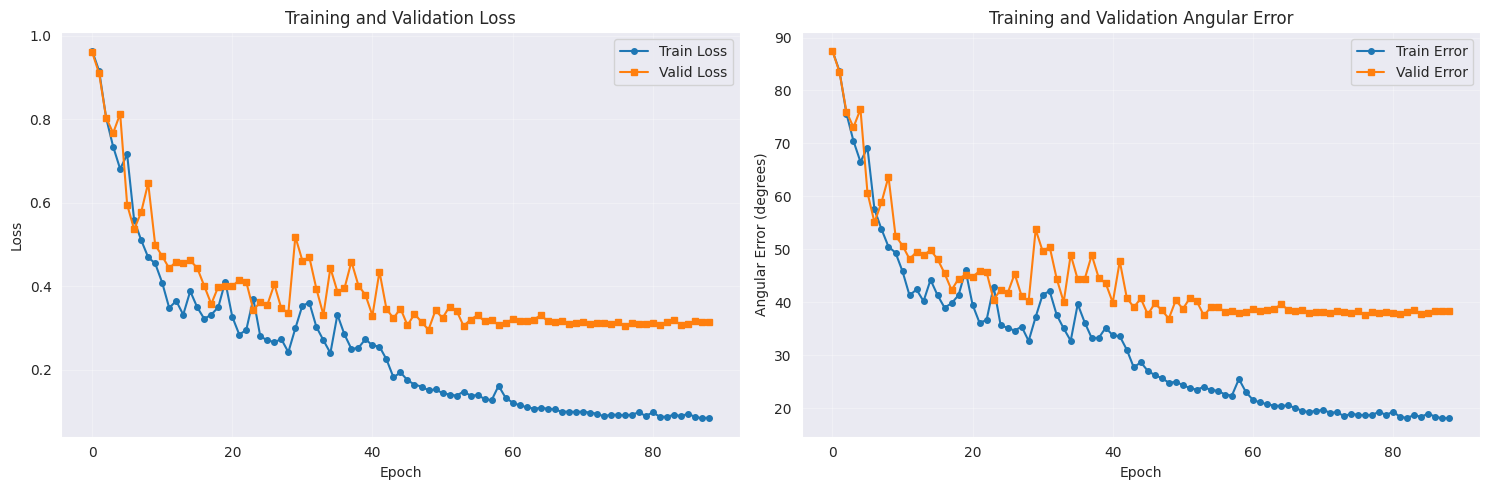

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', markersize=4)
axes[0].plot(history['valid_loss'], label='Valid Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Angular error plot
axes[1].plot(history['train_angle_error'], label='Train Error', marker='o', markersize=4)
axes[1].plot(history['valid_angle_error'], label='Valid Error', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Angular Error (degrees)')
axes[1].set_title('Training and Validation Angular Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path(CONFIG['save_dir']) / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. Load Best Model and Evaluate on Test Set

In [13]:
# Load best model
checkpoint_path = Path(CONFIG['save_dir']) / 'best_model.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Validation loss: {checkpoint['valid_loss']:.4f}")
print(f"  Validation angle error: {checkpoint['valid_angle_error']:.2f}°")

# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = evaluate(model, dataloaders['test'], criterion, device)

print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Mean Angular Error: {test_metrics['angular_error']:.2f}°")
print(f"Median Angular Error: {np.median(test_metrics['all_errors']):.2f}°")
print(f"Std Angular Error: {np.std(test_metrics['all_errors']):.2f}°")
print(f"Max Angular Error: {np.max(test_metrics['all_errors']):.2f}°")

# Error percentiles
print("\nError Percentiles:")
for p in [25, 50, 75, 90, 95]:
    print(f"  {p}th percentile: {np.percentile(test_metrics['all_errors'], p):.2f}°")

# Accuracy at thresholds
print("\nAccuracy at different error thresholds:")
for threshold in [5, 10, 15, 20, 30, 45]:
    accuracy = (test_metrics['all_errors'] <= threshold).mean() * 100
    print(f"  Within {threshold}°: {accuracy:.2f}%")

Loaded best model from epoch 49
  Validation loss: 0.2962
  Validation angle error: 36.90°

Evaluating on test set...


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]


TEST SET RESULTS
Test Loss: 0.3410
Mean Angular Error: 40.61°
Median Angular Error: 27.56°
Std Angular Error: 41.44°
Max Angular Error: 179.73°

Error Percentiles:
  25th percentile: 11.38°
  50th percentile: 27.56°
  75th percentile: 50.36°
  90th percentile: 92.92°
  95th percentile: 147.18°

Accuracy at different error thresholds:
  Within 5°: 11.55%
  Within 10°: 21.62%
  Within 15°: 31.45%
  Within 20°: 39.80%
  Within 30°: 53.56%
  Within 45°: 69.53%


## 14. Error Analysis

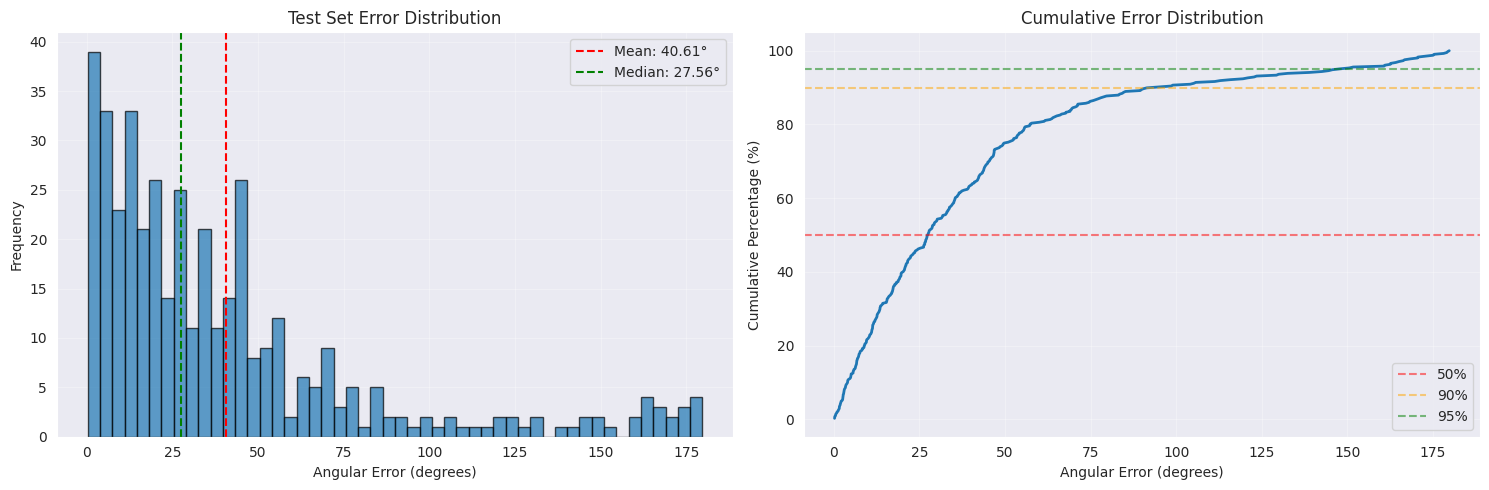

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Error distribution histogram
axes[0].hist(test_metrics['all_errors'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(test_metrics['angular_error'], color='red', linestyle='--',
                label=f"Mean: {test_metrics['angular_error']:.2f}°")
axes[0].axvline(np.median(test_metrics['all_errors']), color='green', linestyle='--',
                label=f"Median: {np.median(test_metrics['all_errors']):.2f}°")
axes[0].set_xlabel('Angular Error (degrees)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Test Set Error Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_errors = np.sort(test_metrics['all_errors'])
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
axes[1].plot(sorted_errors, cumulative, linewidth=2)
axes[1].axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1].axhline(90, color='orange', linestyle='--', alpha=0.5, label='90%')
axes[1].axhline(95, color='green', linestyle='--', alpha=0.5, label='95%')
axes[1].set_xlabel('Angular Error (degrees)')
axes[1].set_ylabel('Cumulative Percentage (%)')
axes[1].set_title('Cumulative Error Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path(CONFIG['save_dir']) / 'error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 15. Visualize Predictions

In [15]:
def visualize_predictions(model, dataloader, device, num_samples=8):
    """Visualize model predictions"""
    model.eval()

    # Get a batch

    # Predict
    with torch.no_grad():
        pred_directions = model(images.to(device)))

    # Convert to angles
    pred_angles = vector_to_angle(pred_directions.cpu())
    true_angles = angles

    # Compute errors
    errors = torch.abs(pred_angles - true_angles)
    errors = torch.min(errors, 360 - errors)  # Handle wraparound

    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(min(num_samples, len(images))):
        # Denormalize image
        img = images[i] * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        # Plot image with arrow
        axes[i].imshow(img)

        # Draw true direction (green)
        cx, cy = img.shape[1] // 2, img.shape[0] // 2
        true_rad = np.radians(true_angles[i])
        true_dx = np.cos(true_rad) * 40
        true_dy = -np.sin(true_rad) * 40  # Negative because y-axis is inverted
        axes[i].arrow(cx, cy, true_dx, true_dy, color='green', width=3,
                     head_width=10, head_length=10, alpha=0.8, label='True')

        # Draw predicted direction (red)
        pred_rad = np.radians(pred_angles[i])
        pred_dx = np.cos(pred_rad) * 40
        pred_dy = -np.sin(pred_rad) * 40
        axes[i].arrow(cx, cy, pred_dx, pred_dy, color='red', width=3,
                     head_width=10, head_length=10, alpha=0.8, label='Pred')

        axes[i].set_title(f"True: {true_angles[i]:.1f}° | Pred: {pred_angles[i]:.1f}°\nError: {errors[i]:.1f}°",
                         fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(Path(CONFIG['save_dir']) / 'predictions_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

# Visualize
print("Visualizing predictions on test set...")
visualize_predictions(model, dataloaders['test'], device, num_samples=8)

SyntaxError: unmatched ')' (ipython-input-3271621877.py, line 9)

## 16. Save Final Results

In [ ]:
# Save final results
results = {
    'config': CONFIG,
    'test_metrics': {
        'loss': test_metrics['loss'],
        'mean_angular_error': test_metrics['angular_error'],
        'median_angular_error': float(np.median(test_metrics['all_errors'])),
        'std_angular_error': float(np.std(test_metrics['all_errors'])),
        'max_angular_error': float(np.max(test_metrics['all_errors'])),
    },
    'training_history': history,
    'best_epoch': checkpoint['epoch']
}

# Save to JSON
with open(Path(CONFIG['save_dir']) / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to:", Path(CONFIG['save_dir']) / 'results.json')
print("\n✓ Training complete! All artifacts saved to:", CONFIG['save_dir'])